# Log-linear models

## Problem statement:

Log-linear models apply to a vector $X$ taking values in $\{0, 1\}^d$. The probability of observing a certain $x$ is such that (for a model restricted to two-order interactions):
$$\log P(X = x) = \alpha + \sum_{i=1}^{d}\beta_ix_i + \sum_{i<j}\gamma_{ij}x_ix_j$$

In [1]:
#importation des packages nécessaire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import multivariate_normal, norm,uniform
import itertools
import pandas as pd
from itertools import product
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from PIL import Image


 ### Question 1-a : Propose and implement an algorithm to sample data from this model (for fixed values of βi)

#### Gibbs sampling (see the picture below)

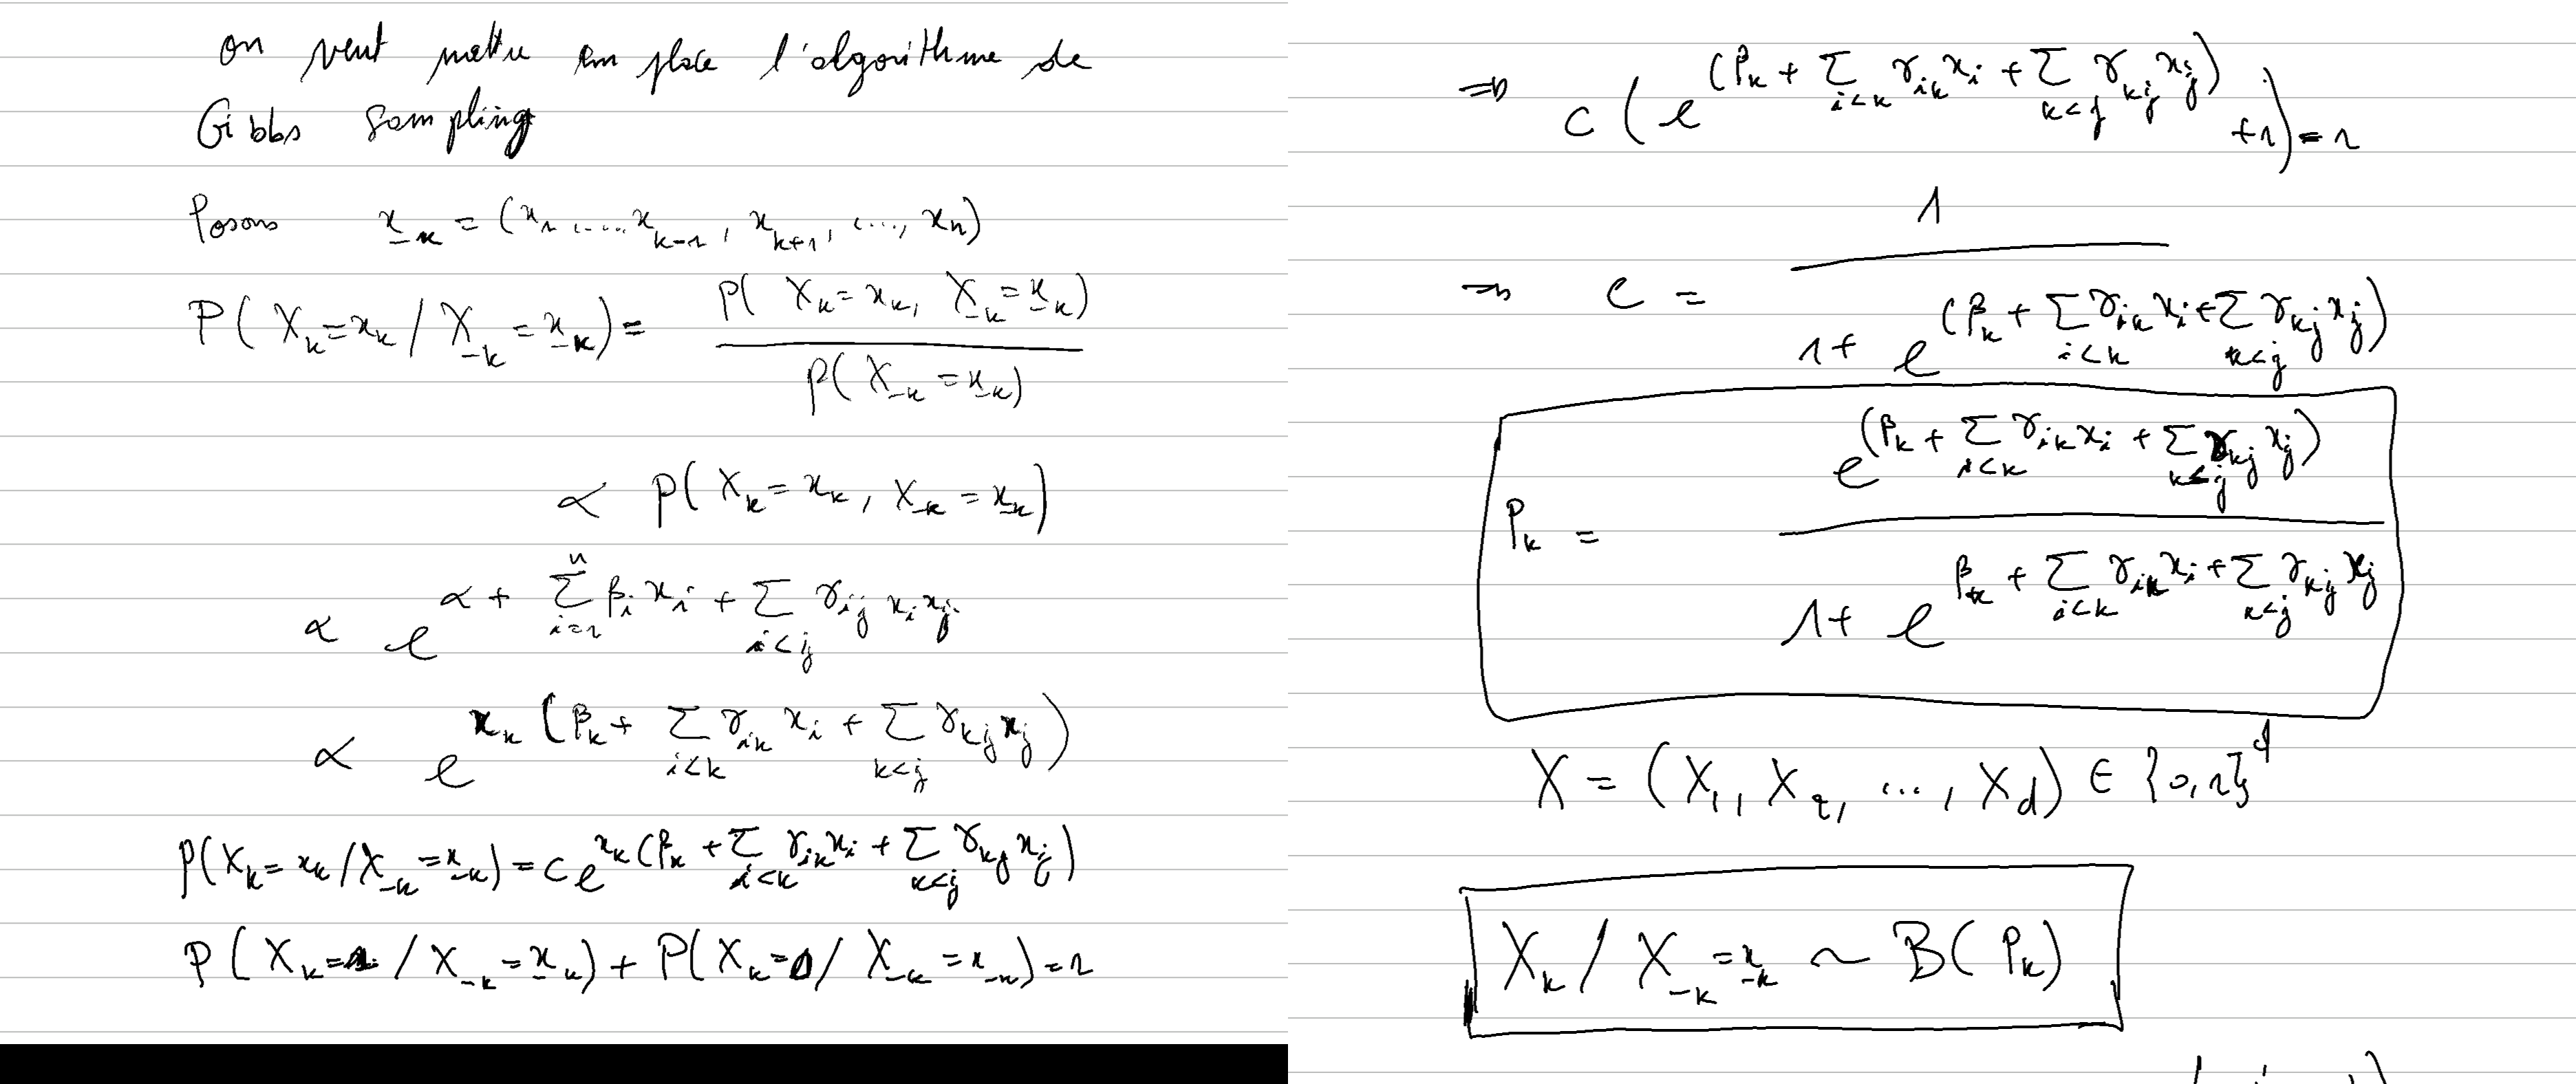

In [2]:
#Montrer les calculs
# Charger les deux images
image1 = Image.open("C:/Users/frank/Desktop/Projet/Part_1.png")
image2 = Image.open("C:/Users/frank/Desktop/Projet/Part_2.png")

# Joindre les deux images horizontalement
image_horizontale = Image.new('RGB', (image1.width + image2.width, max(image1.height, image2.height)))
image_horizontale.paste(image1, (0, 0))
image_horizontale.paste(image2, (image1.width, 0))

# Afficher l'image horizontale
display(image_horizontale)

In [3]:
# Transformer le vecteur gamma en une matrice triangulaire suppérieure pour faciliter les calculs
def Gamma_coef_matrice(gamma,d):
    n=len(gamma)
    Gamma=np.zeros((d,d))
    k=0
    for i in range(d):
        for j in range(i+1,d):
            Gamma[i,j]=gamma[k]
            k+=1
    return Gamma

In [4]:
# Pouvoir recupérer les coéficients a partir d'une matrice triangulaire suppérieure
def matrice_Gamma(Gamma):
    n=Gamma.shape[0]
    gamma=[]
    for i in range(n):
        for j in range(i+1,n):
            gamma.append(Gamma[i,j])
    return gamma

In [5]:
# Calcul de l'exponentielle de la somme se trouvant au numérateur et au dénominateur pour beta, gamma et x donnés
def expo_sum(beta, gamma, k, liste,d):
    Gamma=Gamma_coef_matrice(gamma,d)
    som=beta[k]
    i=0
    while i<k:
        som+=Gamma[i,k]*liste[i]
        i+=1
    j=k+1
    while j<d:
        som+=Gamma[k,j]*liste[j]
        j+=1
    return np.exp(som)

In [6]:
#calcul de la probabilité P_k
def proba(k,liste,d,beta,gamma):
    return expo_sum(beta, gamma, k, liste,d)/(1+expo_sum(beta, gamma, k, liste,d))

In [7]:
# Mise en place de la loi de bernouilli de paramètre P_k
def bernoulli(k,liste,d,beta,gamma):
    return np.random.binomial(1, proba(k,liste,d,beta,gamma))

In [8]:
# Gibbs Sampling algoritm 
def Gibbs_sampling(initial,N_samples,beta,gamma):
    d=len(initial)
    sample = np.empty((N_samples+1, d))
    sample[0,:]=initial
    for i in range(N_samples):
        vector=sample[i,:]
        for k in range(d):
            vector[k]=bernoulli(k,vector,d,beta,gamma)
        sample[i+1,:]=vector
    return sample

**Precision :** The elements of the vector gamma are arranged by row, for example, for d=3., $gamma=[\gamma_{12}\,\gamma_{13},\gamma_{23}]$  and for d=4 $gamma=[\gamma_{12}\,\gamma_{13},\gamma_{14},\gamma_{23},\gamma_{24},\gamma_{34}]$

#### Test of the function Gibbs_sampling

In [9]:
# Pour choisir les coeficients sur plage donnée, mais on peut peu leur choisir manuellement
def generate_coefs(d, a, b):
    beta = np.random.uniform(a, b, d)
    gamma = np.random.uniform(a, b, int(d*(d-1)/2))
    return beta, gamma

**pour d=5**

In [10]:
d,a,b=5,-1,1
beta,gamma=generate_coefs(d, a, b)
print("beta ",beta)
print(" ")
print("gamma ",gamma)
initial=[0,1,0,1,1]
N_samples=10000
samples=Gibbs_sampling(initial,N_samples,beta,gamma)

beta  [-0.66162181  0.85691784  0.96438024 -0.71463398  0.1046303 ]
 
gamma  [-0.85352784 -0.49551243  0.89272624 -0.8324513   0.30016638  0.73559976
  0.49046393  0.02799575 -0.82833001 -0.88019492]


In [11]:
print(samples[:4,:])

[[0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 1. 1. 0. 0.]]


 ### Question 1-b :  How can you check that the corresponding algorithm mixes well in this case?

#### 1)  Prémier élément loi théorique versus loi empirique

Nous considérons la fonction si dessus qui represente la la valeur théorique de $\log P(X=x)-\log P(X=0)$ pour $x$ donné. 
$$x \rightarrow \log P(X=x)-\alpha=\sum_{i=1}^{d}\beta_ix_i + \sum_{i<j}\gamma_{ij}x_ix_j$$
Nous allons comparer ces probabilités théorique à leur valeurs empiriques issues d'un échantillon

In [12]:
# calcul de la fonction ci-dessus en un point x donnée
def log_proba_coef_pret(vector,beta,gamma):
    d=len(beta)
    Gamma=Gamma_coef_matrice(gamma,d)
    som=0
    for i in range(len(vector)):
        som+=vector[i]*beta[i]   
    for j in range(len(vector)):
        i=0
        while i<j:
            som+=Gamma[i,j]*vector[i]*vector[j]
            i+=1
    return som

In [13]:
# calcul de la proportion d'un vecteur donné
def proportion(sample, target_row): # Fonction 
    count = 0
    for row in sample:
        if (row == target_row).all():
            count += 1
    return count/len(sample)

In [14]:
# Avoir toute les valeurs possibles de x
def generate_combinations(d):
    coeffs = [0, 1]  
    comb = list(product(coeffs, repeat=d))  
    X = np.array(comb)  
    return X 

In [15]:
# calcul des valeurs empiriques et théorique
def log_proba_theor_empi(samples,beta,gamma,X):

    propro_0=proportion(samples, X[0,:])
    
    valeur=np.zeros((X.shape[0]-1,2))
    for i in range(1,X.shape[0]):
        valeur[i-1,0]=log_proba_coef_pret(X[i,:],beta,gamma)
        valeur[i-1,1]=np.log(proportion(samples,X[i,:]))- np.log(propro_0)
    return valeur
                        

In [16]:
d,a,b=4,-1,1
beta,gamma=generate_coefs(d, a, b)
X=generate_combinations(d)
sample_size=[150,300,800,2000]
initial=[0,0,1,0]

val_sample_size=[]
for taille in sample_size:
    samples = Gibbs_sampling(initial, taille, beta, gamma)
    val_sample_size.append(log_proba_theor_empi(samples,beta,gamma,X))

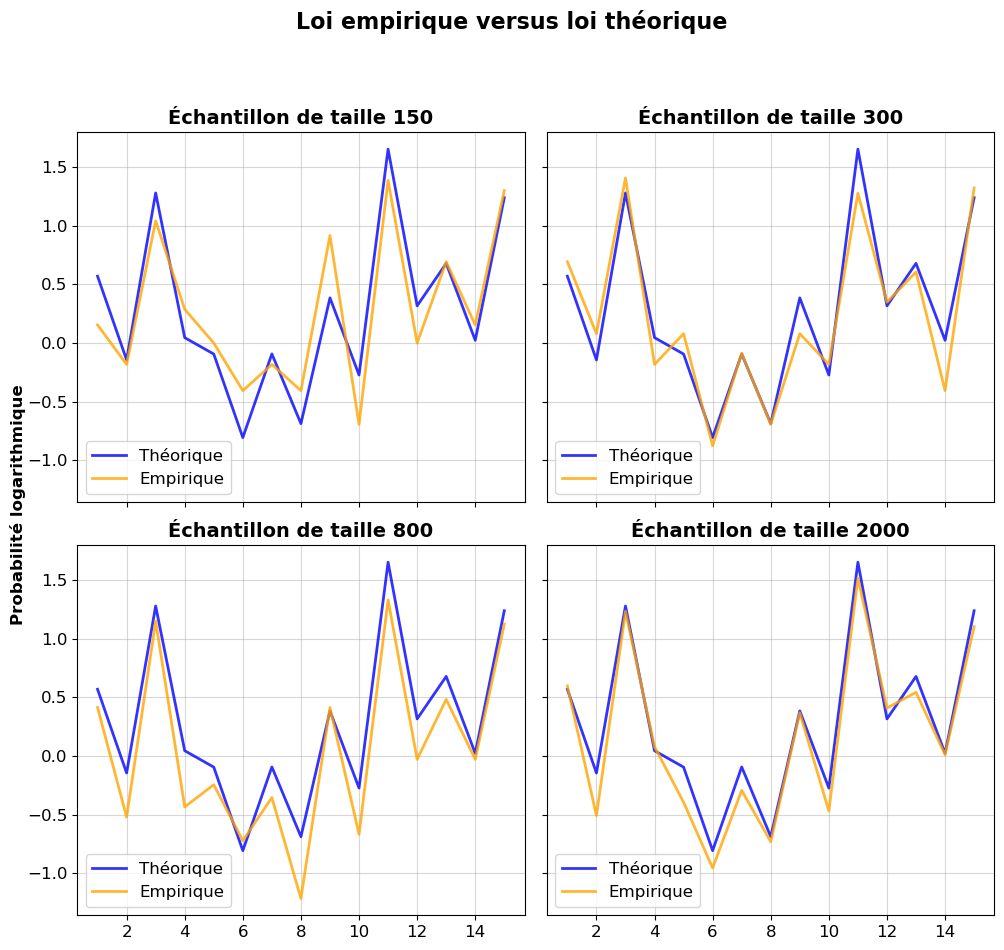

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 9), sharex=True, sharey=True)

colors = ['blue', 'orange']

for i, ax in enumerate(axs.flatten()):
    n = val_sample_size[i].shape[0]
    x = np.linspace(1, n, n)
    for j in range(2):
        ax.plot(x, val_sample_size[i][:,j], color=colors[j], lw=2, alpha=0.8, label=['Théorique', 'Empirique'][j])
    ax.set_title(f'Échantillon de taille {sample_size[i]}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True, alpha=0.5)

fig.suptitle('Loi empirique versus loi théorique', fontsize=16, fontweight='bold', y=1.05)
fig.text(0.5, 0.04, '', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.006, 0.5, 'Probabilité logarithmique', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

#### Etude de l'effet de la mémoire: chaine de Markov 

Pour ce faire, nous utilisons deux méthodes:

1) **La prémière consiste à utiliser la fonction définir à la question précedente**

Mais il faut noter qu'elle n'est pas forcement une bijection. Il n'est pas trivial pour nous de justifier qu'elle transfère les propriétés d'autocorrélation de cette chaine de markow.

2) **La deuxième  consiste a utiliser la bijection de $N^d$ sur $N$**

L'Idée ici est de transférer les propriétes des ces vecteurs sur N est d'évaluer l'autocorrelation sur ces valeurs.
        

In [18]:
taille=150
samples = Gibbs_sampling(initial, taille, beta, gamma)
samples_log_pro=[log_proba_coef_pret(vector=samples[i,:],beta=beta,gamma=gamma) for i in range(samples.shape[0])]

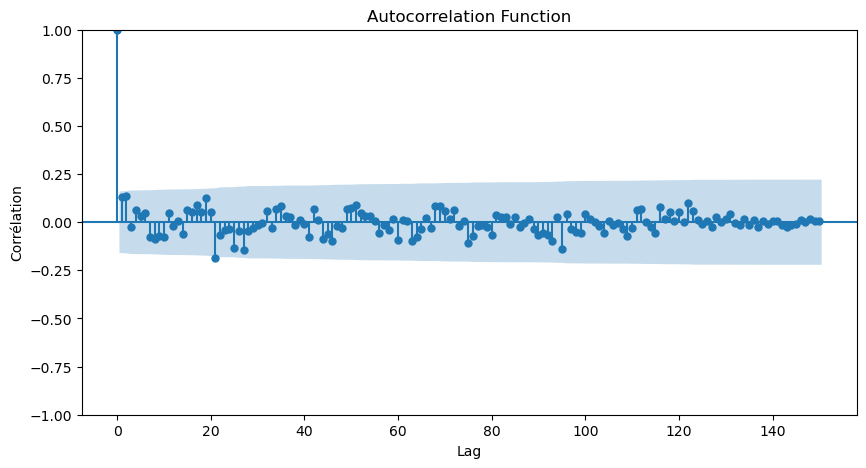

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(np.array(samples_log_pro), ax=ax, lags=range(len(samples_log_pro)))
ax.set_title('Autocorrelation Function')
ax.set_xlabel('Lag')
ax.set_ylabel('Corrélation')
plt.show()

#### La bijection

In [20]:
# bijection de N^2 sur N
def Bijection(i,j):
    return ((i+j) * (i + j + 1)) // 2 + j

In [21]:
# bijection de N^d sur N
def Bijection_d(d, coord):
    if d == 1:
        return coord[0]
    else:
        result = Bijection(coord[0], coord[1])
        for i in range(2, d):
            result = Bijection(result, coord[i])
        return result

In [22]:
samples_map=[Bijection_d(d=2,coord=samples[i,:]) for i in range(samples.shape[0])]

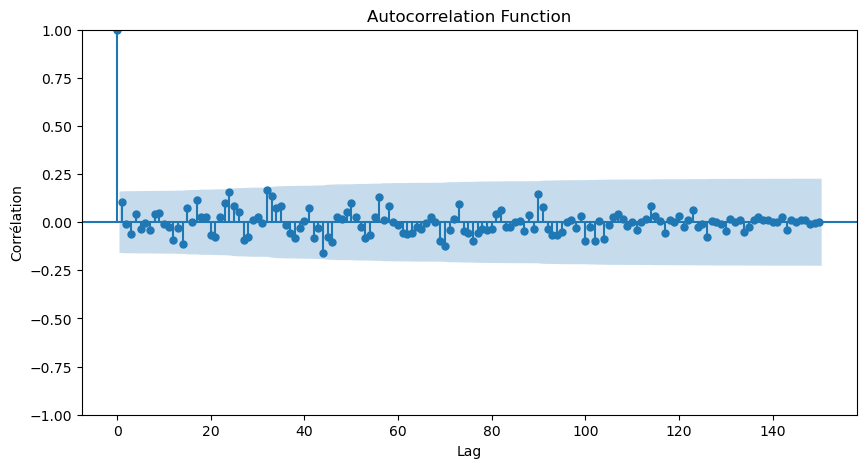

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(np.array(samples_map), ax=ax, lags=range(len(samples_log_pro)))
ax.set_title('Autocorrelation Function')
ax.set_xlabel('Lag')
ax.set_ylabel('Corrélation')
plt.show()

### Conclusion: 
On constate que les deux graphiques sont similaire (**signe de la corrélation et l'amplitude**)
et qu'on ne peut pas rejeter à 5% l'hypothèse selon laquelle chaque est null(pas de mémoire). Ce qui montres qu'on a bien simulé une **chaine de Markow**

##  Question 2

La constante de normalisation $\alpha$ peut être calculée à partir de l'expression:

$$
\alpha = \log \Bigg[ \sum_{x} \exp \bigg( \sum_{i=1}^{d} \beta_i x_i + \sum_{i<j} \gamma_{ij} x_i x_j \bigg) \Bigg]
$$

Le problème pratique avec le calcul de $\alpha$ est que la somme peut devenir très grande pour les modèles avec un grand nombre de variables, ce qui peut conduire à des erreurs numériques ou à des temps de calcul très longs.

##  Question 3

L'idée ici est d'utiliser un proposal qui prend en compte l'information sur les paramètres contenu dans l'échantillon. Nous tenons compte des points suivants:

1) **On remarque que les vecteurs ayant $1$ à la position $i$ et $0$ partout ailleurs donnent une information sur $\beta_i$**

2) **Que les vecteurs ayant $1$ à la position $i$ et $j$ et $0$ partout ailleurs donnent une information sur $\gamma_{i,j}$**

3) **Pour calculer la vraisemblance comme le produit le produit des densitées, on se rassure d'avoir une échantillon iid** 

4) **Etant donné qu'a priori, nous ne disposons pas d'information sur ces paramètres, nous proposons comme loi à priori une une gaussienne avec une très grande variance, qui est approximation de la mesure de Lesbegue** 

In [24]:
# Prend en entrée les coéficients alpha, beta et Gamma et renvoye un vecteur
def Coefs_vector(beta,gamma):
    theta=beta+gamma
    return theta  

In [25]:
# Prend en entrée les coéficients alpha, beta et Gamma et renvoye un vecteur
def vector_coef(theta,d):
    n=len(theta)
    len_beta=d
    beta=[theta[i] for i in range(len_beta)]
    gamma=[theta[i] for i in range(len_beta,n)]
    return beta,gamma

In [26]:
# Calcul la valeur du log proposal en un point x=[beta,gamma] donné
# RAPPEL: la moyenne de se proposal dependra de l'information recueilli sur l'échantillon
def log_posterior_proposal(mean,pas, x):
    mvn = multivariate_normal(mean=mean, cov=pas*np.eye(len(mean)))
    return mvn.logpdf(x)

In [27]:
# un proposal Gaussien donc la moyenne sera préciser le moment venu
def posterior_proposal(moyen,pas):   
    theta =moyen+pas*np.random.multivariate_normal(mean=np.zeros(len(moyen)), cov=np.eye(len(moyen)))
    return theta

In [28]:
# Calcul la log vraisemblance pour un échantillon X et les paramètres theta=[beta, gamma] donné
def log_Likelihood(X,theta,d):
    beta, gamma=vector_coef(theta,d)
    Gamma=Gamma_coef_matrice(gamma,d)
    # Calculer la log-vraisemblance
    scores = np.dot(X, beta)
    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            scores += Gamma[i,j] * X[:,i] * X[:,j]
    return np.sum(scores)

In [29]:
# Calcul la valeur du log proposal en un point x=[beta,gamma] donné
def log_prior(mean, sigma, x):
    mvn = multivariate_normal(mean=mean, cov=sigma*np.eye(len(mean)))
    return mvn.logpdf(x)

In [30]:
# Calcul le logarithme du numerateur et du dénominateur du rapport a
def somme_rapport_accept(x,w,theta_new,theta,mean_prior,sigma_prior,mean_proposal,pas_proposal):
    return log_posterior_proposal(mean_proposal,pas_proposal,theta)+log_prior(mean_prior,sigma_prior,theta_new) + log_Likelihood(x,theta_new,d) + log_Likelihood(w,theta,d)

In [31]:
# Simuler un échantillon X iid de taille N_samples pour beta et gamma donné
# Pour se faire on simule N_samples fois un échantillon de taille de n_time avec chaque fois un point initial different
# et a chaque fois on garde le derniers élément
def Gibbs_sampling_iid(n_times,N_samples,beta,gamma,d):
    samples=np.empty((N_samples,d))
    for i in range(N_samples):
        initial=[]
        for j in range(d):
            initial.append(np.random.binomial(1,0.5))
        samples[i,:]=Gibbs_sampling(initial,n_times,beta,gamma)[-1,:]
    return samples
        

Ici on extrait l'information sur les paramètres contenu dans un échantillon donnée

l'information sur $\beta_i$ étant donné par la fréquence du vecteur ayant $1$ à la position $i$ et zero partout ailleurs sur la frequence du vecteur dont les coéfficients sont égaux à $0$ 

l'information sur $\gamma_{i,j}$ étant donné par la fréquence du vecteur ayant $1$ à la position $i$ et $j$ et zero partout ailleurs fois la frequence du vecteur dont les coéfficients sont égaux à $0$ diviser par pe produit des frequences des vecteurs ayant $1$ respectivement aux position $i$ et $j$ 

In [32]:
def estimator(sample) :
    d = sample.shape[1] # Dimension de l'espace
    nul = [0]*d
    beta =nul  # Initialisation de beta
    gamma = np.zeros((d, d)) # Initialisation de gamma

    prop_zero = proportion(sample, nul) # Estimateur de alpha
    
    iden = np.eye(N=d,dtype='int').tolist()
    for i in range(d) :
        prop_i = proportion(sample, iden[i])
        beta[i] = np.log(prop_i/prop_zero)
        
        for j in range(i+1, d) :
            vec = np.zeros(d)
            vec[i] = 1
            vec[j] = 1
            vec = vec.tolist()
            
            gamma[i, j] = np.log(proportion(sample, vec)*prop_zero) - np.log(prop_i*proportion(sample, iden[j]))    
    return beta, gamma

In [94]:
#Mise en place de l'algorithme d'échange 
def Exchange_1_algorithm(X,beta_init,gamma_init,T, mean_prior,sigma_prior,mean_proposal,pas_proposal,n_times):
    d=len(beta_init)
    theta=Coefs_vector(beta_init,gamma_init)
    N_samples_w=X.shape[0]
    parametres=np.zeros((T,len(theta)))
    acceptance=0
    for i in range(T):
        # Proposer un nouveau theta
        theta_new= posterior_proposal(mean_proposal,pas_proposal)
       
        # Generation de variables auxiliaire
        beta_new,gamma_new=vector_coef(theta_new,d)
        w=Gibbs_sampling_iid(n_times,N_samples_w,beta_new,gamma_new,d)
        
        # Calcule du log ration
        mun=somme_rapport_accept(X,w,theta_new,theta,mean_prior,sigma_prior,mean_proposal,pas_proposal)
        deno=somme_rapport_accept(X,w,theta,theta_new,mean_prior,sigma_prior,mean_proposal,pas_proposal)
        a=mun-deno
        
        #accepte ou rejete
        
        if np.log(np.random.rand())<a: 
            theta=theta_new
            acceptance+=1

         
        parametres[i,:]=theta
        
    return parametres, acceptance/parametres.shape[0]

In [80]:
d,a,b=3,-1,1
beta,gamma=generate_coefs(d, a, b)

In [81]:
print('beta',beta)
print("gamma",gamma)

beta [ 0.23115292 -0.49461118  0.52647035]
gamma [-0.60630298 -0.17348174  0.60098166]


In [236]:
beta_init,gamma_init=generate_coefs(d, a, b); beta_init=beta_init.tolist(); gamma_init=gamma_init.tolist()


T=3000; n=int(d+d*(d-1)/2); mean_prior=[0]*n; sigma_prior=100000; N_samples=1000; n_times=10

pas_proposal=0.05

samples=Gibbs_sampling_iid(n_times,N_samples,beta,gamma,d)

beta_est,Gamma_est=estimator(samples)

gamma_est=matrice_Gamma(Gamma_est)

mean_proposal=Coefs_vector(beta_est,gamma_est)

In [37]:
# Détermination du meilleur taux d'acceptation en fonction du proposal
pas=np.linspace(0.01,0.05,5).tolist()
taux_accep=[]
for pas_proposal in pas:
    parametres,accep_rate=Exchange_1_algorithm(samples,beta_init,gamma_init,T, mean_prior,sigma_prior,mean_proposal,pas_proposal,n_times)
    taux_accep.append([pas_proposal,accep_rate])

C:\Users\frank\AppData\Local\Temp\ipykernel_61976\2128156312.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  graph=np.array(taux_accep)


Text(0.5, 1.0, "Taux d'acceptation en fonction du pas du proposal")

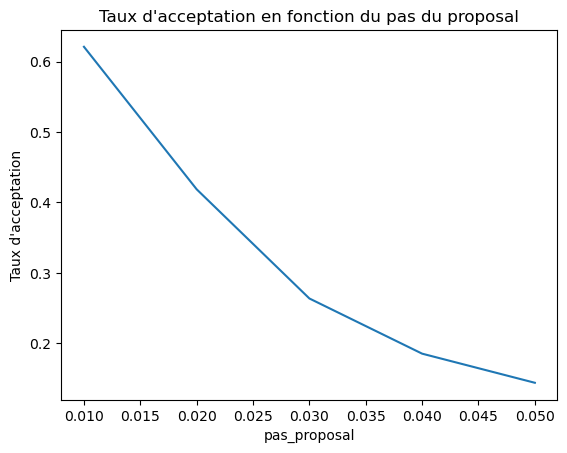

In [83]:
# Tracer du graphe taux d'acceptation en fonction du pas du proposal
graph=np.array(taux_accep)
plt.plot(pas,graph[:,1])
plt.xlabel("pas_proposal")
plt.ylabel("Taux d'acceptation")
plt.title("Taux d'acceptation en fonction du pas du proposal")

In [84]:
pas_proposal_taux_max=0.03

In [85]:

parametres,accep_rate=Exchange_1_algorithm(samples,beta_init,gamma_init,T, mean_prior,sigma_prior,mean_proposal,pas_proposal_taux_max,n_times)

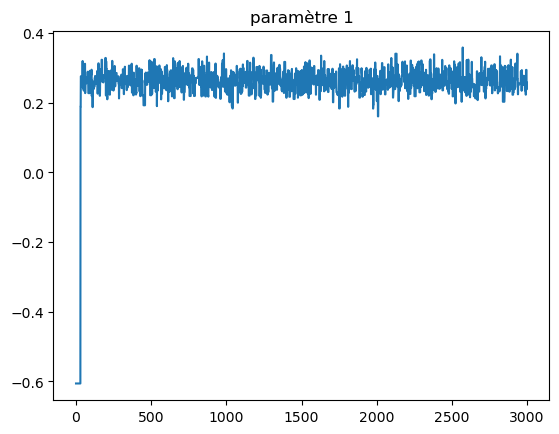

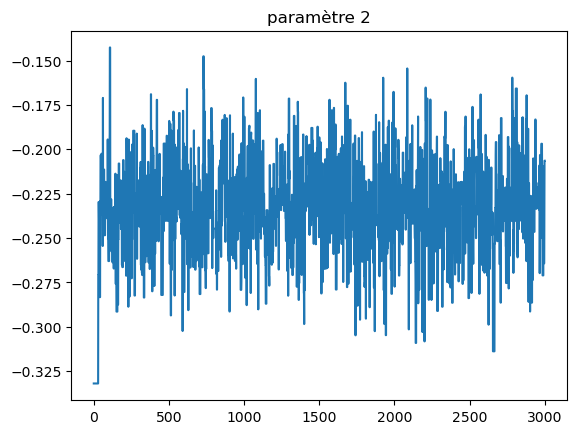

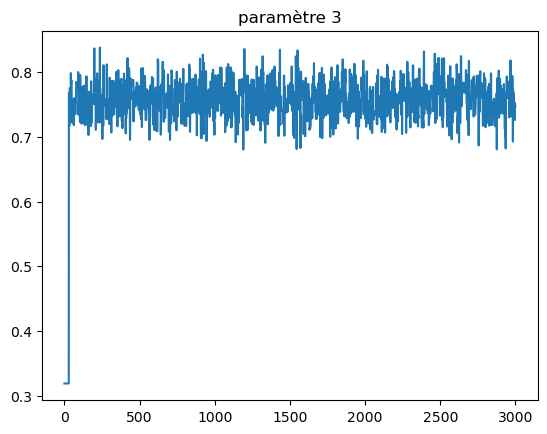

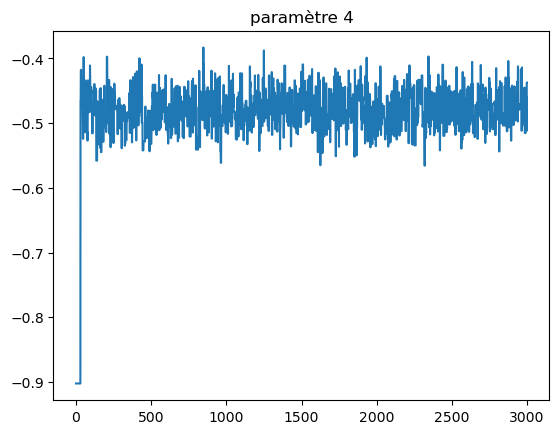

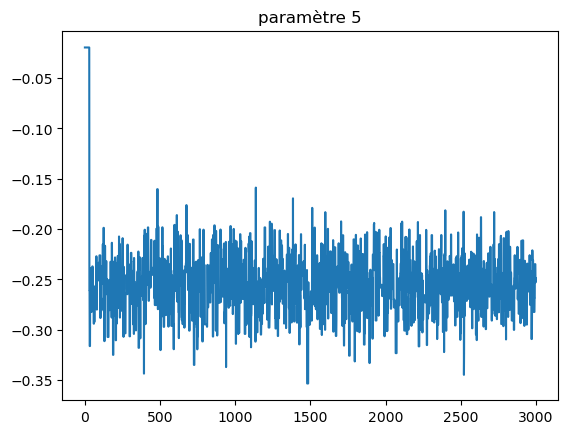

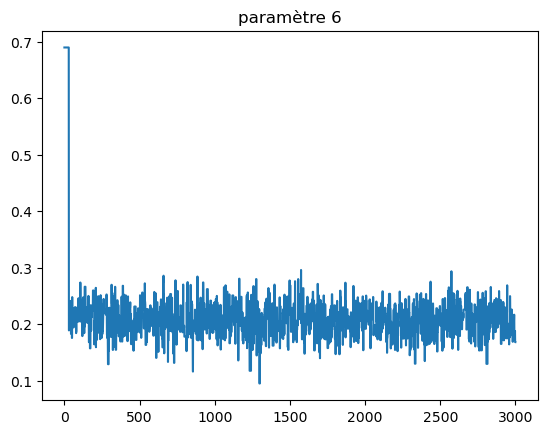

In [87]:
for col in range(parametres.shape[1]):
    plt.plot(parametres[:,col])
    plt.title(f'paramètre {col+1}')
    plt.show()

In [89]:
print('beta',beta)
print('estimation de beta', np.mean(parametres[10:,0:3],axis=0))
print(' ')
print('gamma',gamma)
print("estimation de gamma", np.mean(parametres[10:,3:],axis=0))

beta [ 0.23115292 -0.49461118  0.52647035]
estimation de beta [ 0.25678761 -0.23387968  0.75497441]
 
gamma [-0.60630298 -0.17348174  0.60098166]
estimation de gamma [-0.48272222 -0.25576483  0.21017533]


In [235]:
def plot_parametres(parametres):
   

    # Boucle pour tracer les graphiques pour chaque paramètre
    for i in range(parametres.shape[1]):

        mean = np.mean(parametres[:,i])
        variance = np.var(parametres[:,i])

        # Créer l'histogramme des fréquences relatives
        fig, ax = plt.subplots()
        hist, bins, _ = ax.hist(parametres[:,i], bins=20, density=True, alpha=0.5)

        # Calculer la densité de la loi normale
        x = np.linspace(np.min(parametres[:,i]), np.max(parametres[:,i]), 1000)
        pdf = norm.pdf(x, loc=mean, scale=np.sqrt(variance))

        # Tracer la densité de la loi normale
        ax.plot(x, pdf, 'r', lw=2)

        # Ajouter la ligne verticale pour la moyenne
        ax.axvline(mean, color='black', linestyle='--')
        ax.text(mean, 0, f' : {mean:.2f}', ha='center')

        # Personnalisation des axes et de la légende
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Fréquence relative')
        ax.legend(['Loi normale', 'Histogramme'])

        # Ajuster les limites des axes pour une meilleure lisibilité
        ax.set_xlim(np.min(parametres[:,i]), np.max(parametres[:,i]))
        ax.set_ylim(0, np.max(hist)*1.1)

        # Ajouter un titre pour chaque graphique
        ax.set_title(f'Paramètre {i+1}')

        # Afficher le graphique
        plt.show()


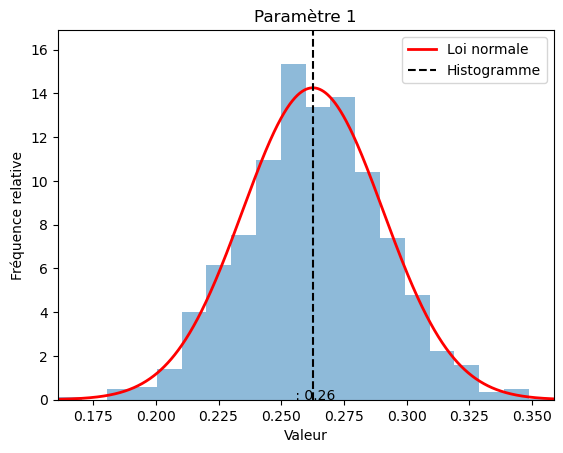

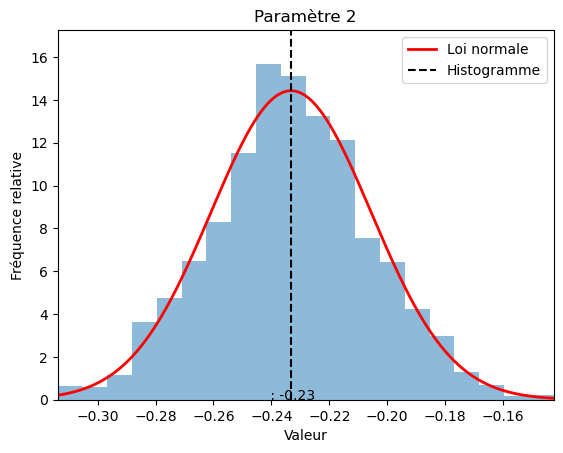

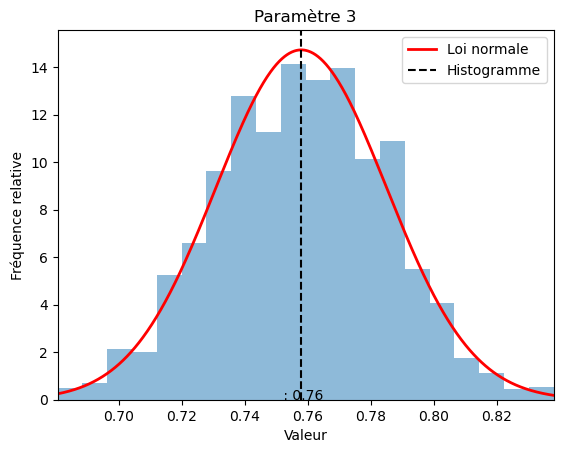

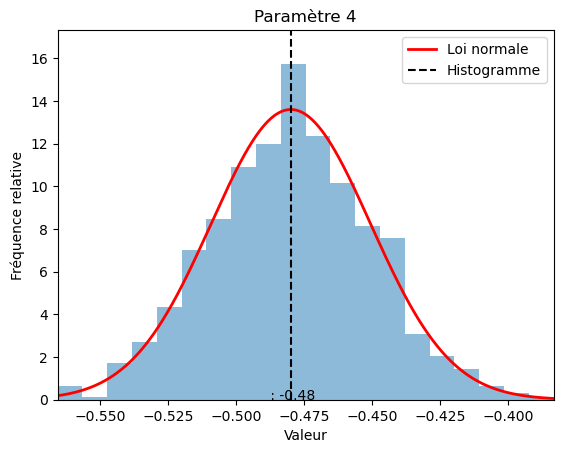

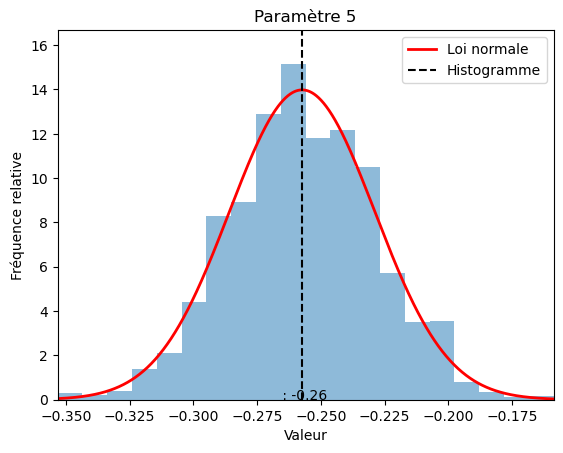

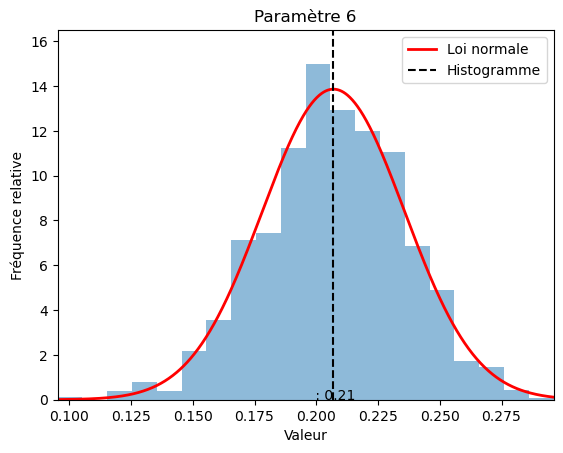

In [92]:
parametres=parametres[20:,:]
plot_parametres(parametres)

## Evaluation de l'estimateur

In [238]:
m=50
estimation=np.empty((m,n))
T=800
for i in range(m):
    parametres,accep_rate=Exchange_1_algorithm(samples,beta_init,gamma_init,T, mean_prior,sigma_prior,mean_proposal,pas_proposal_taux_max,n_times)
    estimation[i,:]=np.mean(parametres[15:,:],axis=0)

In [246]:
print('beta', beta)
print("gamma",gamma)

beta [ 0.23115292 -0.49461118  0.52647035]
gamma [-0.60630298 -0.17348174  0.60098166]


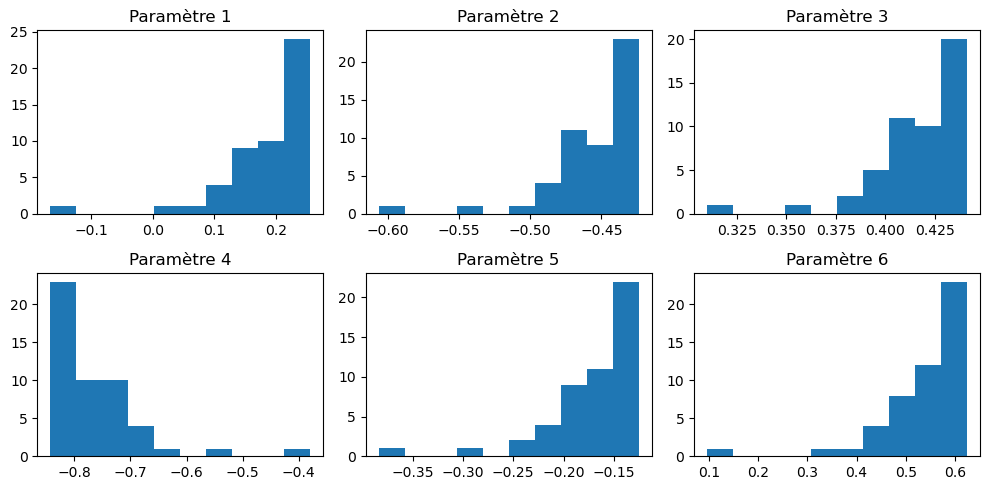

In [255]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes.flatten()):
    ax.hist(estimation[:, i])
    ax.set_title(f'Paramètre {i+1}')
    
plt.tight_layout()
plt.show()

### Question 4: Application

In [194]:
#telecharger la base
titanic=sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [200]:
# Choix des variables
variables_mapper=['sex','alone']
titanic_sample=titanic[variables_mapper]

In [203]:
#Codification des variables
sexe_map={"male":1,"female":0}
alone_map={True:1,False:0}
map_transform=[sexe_map,alone_map]

In [204]:
# suite de la codification des variables
for var,mapper in zip(variables_mapper,map_transform):
    titanic_sample[var]= titanic_sample[var].map(mapper)

C:\Users\frank\AppData\Local\Temp\ipykernel_61976\3342521328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_sample[var]= titanic_sample[var].map(mapper)
C:\Users\frank\AppData\Local\Temp\ipykernel_61976\3342521328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_sample[var]= titanic_sample[var].map(mapper)


In [205]:
# Ajout de la variable survived
titanic_sample["survived"]=titanic["survived"]

C:\Users\frank\AppData\Local\Temp\ipykernel_61976\813236315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_sample["survived"]=titanic["survived"]


In [206]:
titanic_sample.head()

,sex,alone,survived
0,1,0,0
1,0,0,1
2,0,1,1
3,0,0,1
4,1,1,0


In [207]:
# Transformation de l'échantillon obtenu en un tableau numpy
titanic_sample=np.array(titanic_sample)

In [256]:
#Initialisation et application
beta_init=[0.6,-0.2,0.5]; gamma_init=[2,-1.5,0.5]; d=3; T=3000; mean_prior=[0]*6; sigma_prior=10000000; 
pas_proposal=0.01; N_samples=titanic_sample.shape[0]; n_times=20

beta_est,Gamma_est=estimator(titanic_sample)

gamma_est=matrice_Gamma(Gamma_est)

mean_proposal=Coefs_vector(beta_est,gamma_est)

parametres,accep_rate=Exchange_1_algorithm(titanic_sample,beta_init,gamma_init,T, mean_prior,sigma_prior,mean_proposal,pas_proposal,n_times)

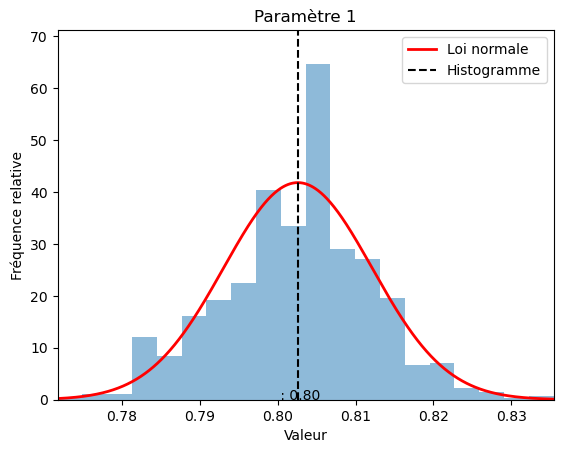

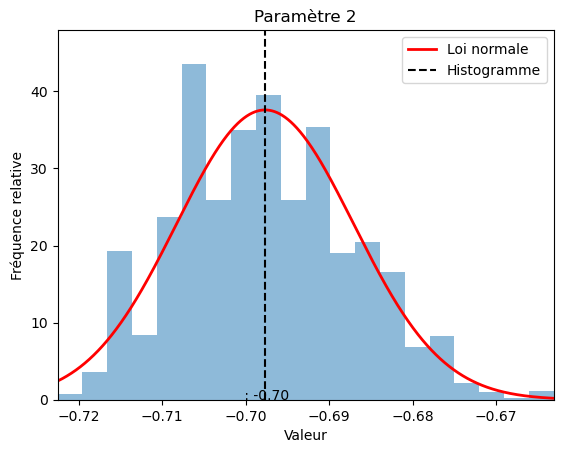

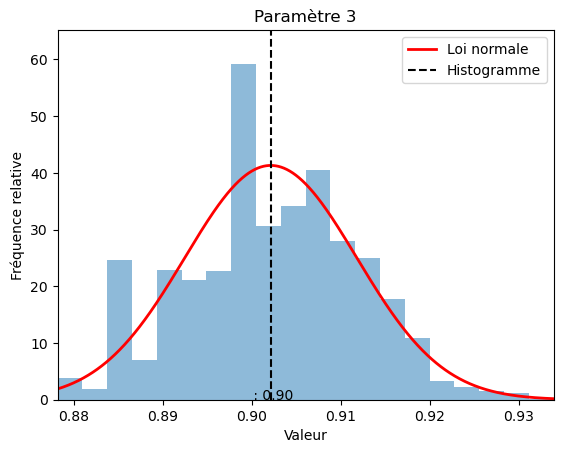

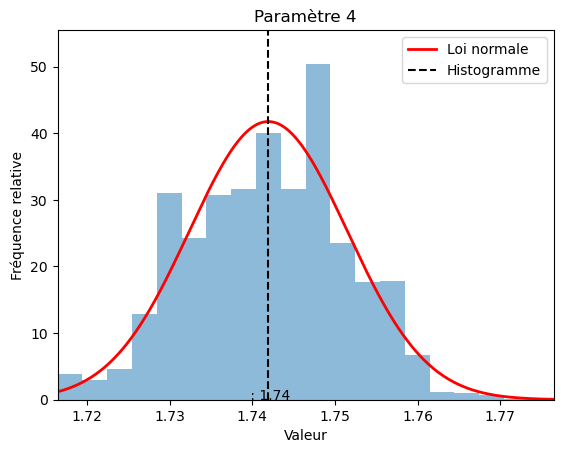

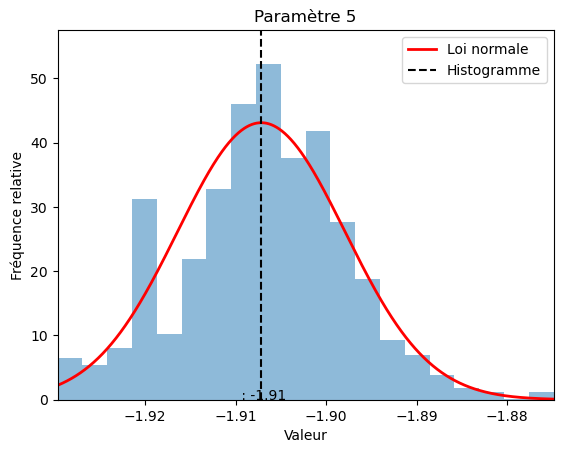

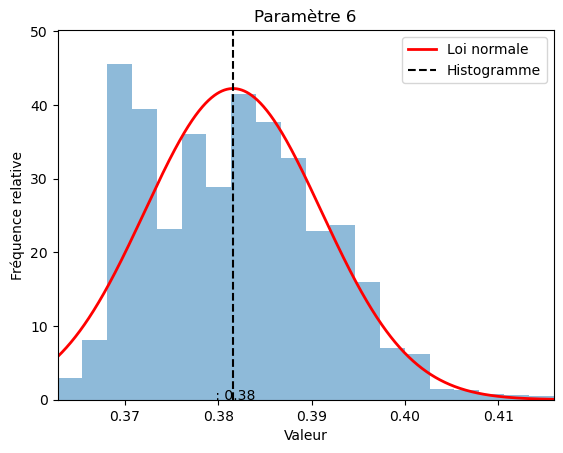

In [261]:
# distribution des paramètres
plot_parametres(parametres[20:,:])

In [259]:
#### taux d'acceptation
accep_rate

0.24333333333333335

In [265]:
#sex, alone, survivel
beta=np.mean(parametres[20:,:],axis=0)
print(beta)

[ 0.80258805 -0.69767326  0.90210629  1.74193981 -1.90717896  0.38158251]


In [266]:
np.exp(sum(beta))

3.3986029613565494